**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be first graded  on a 0-4 scale, following the standard NJIT convention (A:4, B+: 3.5, B:3, C+: 2.5, C: 2, D:1, F:0). However, any given item may be worth 4 or 8 points; if an item is worth 8 points, you need to accordingly scale the 0-4 grade.


The total score must be re-scaled to 100. That should apply to all future assignments so that Canvas assigns the same weight on all assignments.



**Installing and Importing required modules**

In [1]:
!pip install d2l==0.16.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00


In [2]:
from d2l import torch as d2l
import torch
from torch import nn

# <font color = 'blue'>  **Assignment 3**

This assignment tries to further develop your understanding of Convolutional Neural Networks. The notebook is based on the Alexnet noteebook from lecture 4.


In [3]:

net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

We construct a single-channel data example with both height and width of 224 to observe the output shape of each layer.


In [4]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

## Reading the Dataset

Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here
since training an ImageNet model to convergence could take hours or days
even on a modern GPU.
One of the problems with applying AlexNet directly on Fashion-MNIST
is that its images have lower resolution ($28 \times 28$ pixels)
than ImageNet images.
To make things work, we upsample them to $224 \times 224$
(generally not a smart practice,
but we do it here to be faithful to the AlexNet architecture).
We perform this resizing with the `resize` argument in the `d2l.load_data_fashion_mnist` function.


In [5]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

100%|██████████| 26421880/26421880 [00:01<00:00, 17045551.44it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275072.23it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4926350.35it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17413126.61it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss 0.323, train acc 0.882, test acc 0.879
2309.4 examples/sec on cuda:0


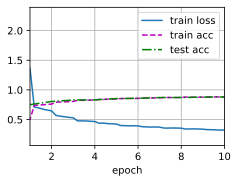

In [6]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

______________



## <font color = 'blue'>  **Question 1** <font>

<font color = 'blue'>  Alexnet was written for images of size 224x224. Clearly it is an overkill for the Fashion MNIST data set which has size 28x28.

<font color = 'blue'> (i) Construct a model that mimics the architecture of Alexnet, but works directly on images of size 28x28.

<font color = 'blue'> (ii) What is the accuracy you reach?

<font color = 'blue'> (iii) Also compare the running time of your model with that of the original Alexnet on the resized images.

<font color = 'blue'>[**Guidelines**: In general, here you probably want to use smaller kernels, and fewers convolutional layers. The most important part of this exercise is to get the dimensions of the layers correct, so that the model works. Try not to use 'Lazy' layers, so that you better understand the dimensions. Also some experimentation with different designs would be good. Feel free to discuss all experiments you did.]


### (i) Construct a model that mimics the architecture of Alexnet, but works directly on images of size 28x28.


In [7]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [8]:
net_Q1 = nn.Sequential(
    # Here, we use a 3 x 3 window to capture objects. At the same
    # time, we use a stride and padding of 1 to keep the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(16, 32, kernel_size=3, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(32, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512, 256), nn.ReLU(),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(256, 10))

loss 0.366, train acc 0.865, test acc 0.841
16063.2 examples/sec on cuda:0


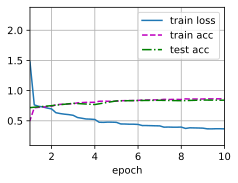

In [9]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net_Q1, train_iter, test_iter, num_epochs, lr)

______________

### (ii) What is the accuracy you reach?

Using the same number of epochs and lr:

Train Accuracy: 86.5% \
Test Accuracy: 84.1% \

The original AlexNet is marginally better with train and test accuracy 88.2% and 87.9%, compared to 86.5% and 81.1% for the smaller model

______________

### (iii) Also compare the running time of your model with that of the original Alexnet on the resized images.

The smaller model was 4 times faster to train. The original took 8 minutes while the smaller model took 2 minutes.

______________

In [10]:
# for grader use only

# insert grade here  (out of 12)

# G[1] =
#
# please justify point subtractions when needed



## <font color = 'blue'>  **Question 2** <font>

<font color = 'blue'>  Now let's go back to the original Alexnet. In the class we trained it for 10 epochs.

<font color = 'blue'>  (i) Train it for 50 epochs and record the training and test accuracy.

<font color = 'blue'>  (ii) Take the MNIST dataloader and modify it, so that each image in the dataset gets a **random** label, in place of its correct label.

<font color = 'blue'>  (iii) Retrain AlexNet with the new modified dataset. This time train it for 500 epochs. What is the training and test accuracy? Can you justify them? Discuss your thoughts.





### (i) Train it for 50 epochs and record the training and test accuracy.

In [11]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss 0.173, train acc 0.936, test acc 0.898
15371.0 examples/sec on cuda:0


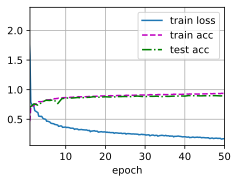

In [12]:
lr, num_epochs = 0.01, 50
d2l.train_ch6(net_Q1, train_iter, test_iter, num_epochs, lr)

Train Accuracy: 93.6% \\
Test Accuracy: 89.8% \\

______________

### (ii) Take the MNIST dataloader and modify it, so that each image in the dataset gets a random label, in place of its correct label.

In [13]:
# Random datasets

batch_size = 128
r_train, r_test = d2l.load_data_fashion_mnist(batch_size)

In [14]:
# Setting targets to a random tensor with digits from 0-9

r_train.dataset.targets = torch.randint(0,10,
                                        r_train.dataset.targets.shape)
r_test.dataset.targets = torch.randint(0,10,
                                       r_test.dataset.targets.shape)

______________

### (iii) Retrain AlexNet with the new modified dataset. This time train it for 500 epochs. What is the training and test accuracy? Can you justify them? Discuss your thoughts.

loss 0.001, train acc 1.000, test acc 0.097
15657.5 examples/sec on cuda:0


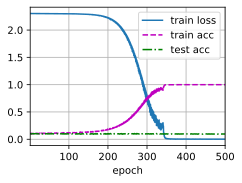

In [15]:
lr, num_epochs = 0.01, 500
d2l.train_ch6(net_Q1, r_train, r_test, num_epochs, lr)

Training Accuracy: 100% \\
Test Accuracy: 9.7% \\

It's clear that the model overfitted on the training data, as the training accuracy was 100% and the testing accuracy was 9.7%. The model performed perfectly on the training data as it just memorized the dataset. The test result also makes sense; since there are 10 possible outputs and the labels were made random, the model has to guess randomly. 10 possible choices means that it has a 10% chance of guessing correctly, hence the accuracy.

______________

In [16]:
# for grader use only

# insert grade here  (out of 12)

# G[2] =
#
# please justify point subtractions when needed

In [ ]:
# total score
max_score = 24
final_score = sum(G)*(100/max_score)
final_score